Random Forest - Accuracy: 0.8813434829059829
Random Forest - Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.85      0.88      7560
           1       0.86      0.91      0.88      7416

    accuracy                           0.88     14976
   macro avg       0.88      0.88      0.88     14976
weighted avg       0.88      0.88      0.88     14976

Random Forest - Confusion Matrix:
 [[6462 1098]
 [ 679 6737]]
Random Forest - Specificity: 0.8547619047619047


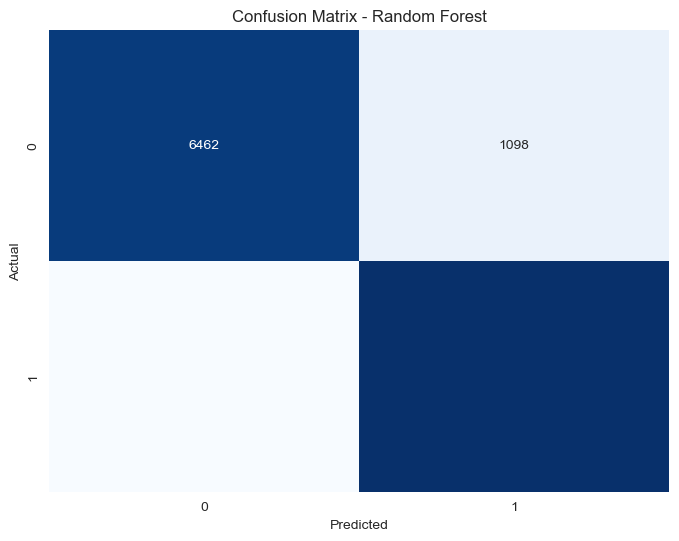

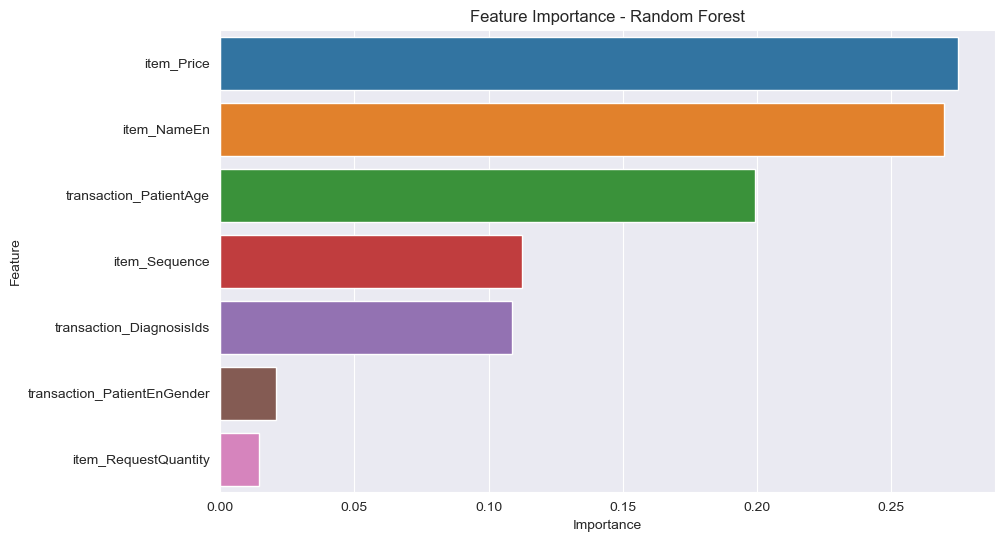

XGBoost - Accuracy: 0.8397435897435898
XGBoost - Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.81      0.84      7560
           1       0.82      0.87      0.84      7416

    accuracy                           0.84     14976
   macro avg       0.84      0.84      0.84     14976
weighted avg       0.84      0.84      0.84     14976

XGBoost - Confusion Matrix:
 [[6097 1463]
 [ 937 6479]]
XGBoost- Specificity: 0.8064814814814815


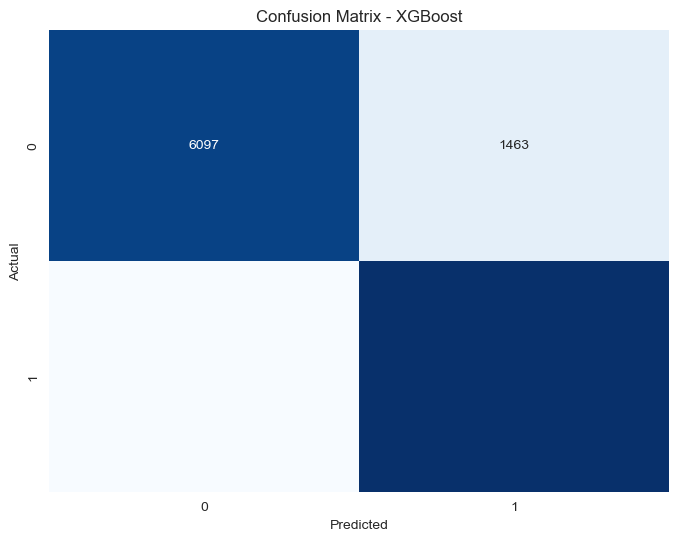

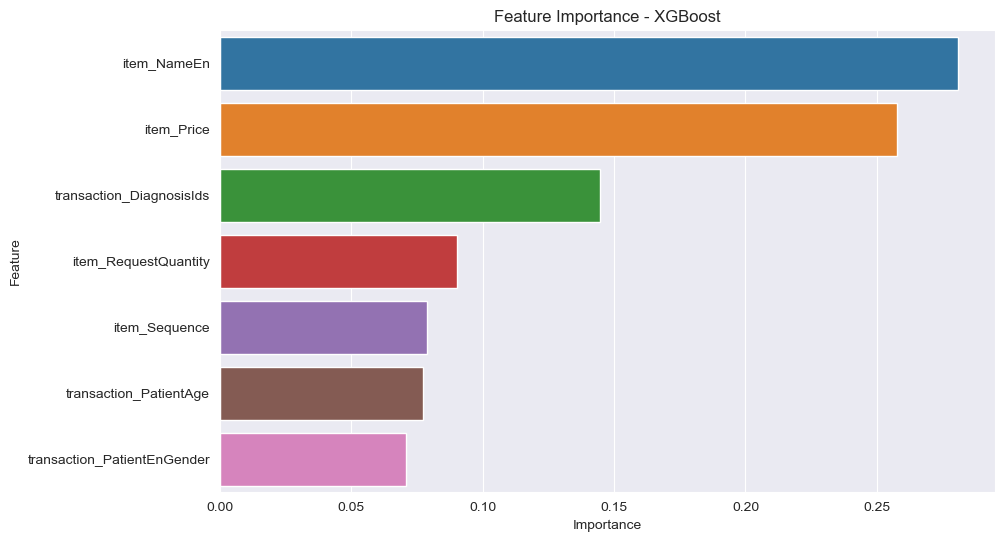

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier

def load_data(file_path):
    """Load data from a CSV or Excel file."""
    if file_path.endswith('.csv'):
        return pd.read_csv(file_path)
    elif file_path.endswith('.xlsx'):
        return pd.read_excel(file_path)
    else:
        raise ValueError("Unsupported file format. Only CSV and Excel files are supported.")

def preprocess_data(df):
    """Preprocess the data."""
    # Drop any missing values if needed
    df.dropna(inplace=True)
    # Perform any other preprocessing steps such as encoding categorical variables
    
    return df

def preprocess_target(target_series):
    """Preprocess the target column."""
    return target_series.apply(lambda x: 1 if x == 'approved' else 0)

def tune_classifier(model, X_train, y_train, params):
    """Tune the classifier using grid search."""
    grid_search = GridSearchCV(model, params, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_

def evaluate_model(model, X_test, y_test):
    """Evaluate the model on the test set."""
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    return accuracy, report, cm

def display_feature_importance(model, feature_names, model_name):
    """Display feature importance."""
    importance = model.feature_importances_
    feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title(f'Feature Importance - {model_name}')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()
def calculate_specificity(cm):
    """Calculate specificity from confusion matrix."""
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    return specificity

def plot_confusion_matrix(cm, model_name):
    """Plot confusion matrix."""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def main(train_file, test_file, feature_columns, target_column):
    # Load train and test data
    df_train = load_data(train_file)
    df_test = load_data(test_file)
    
    # Preprocess data
    df_train = preprocess_data(df_train)
    df_test = preprocess_data(df_test)
    
    # Preprocess target column
    df_train[target_column] = preprocess_target(df_train[target_column])
    df_test[target_column] = preprocess_target(df_test[target_column])
    
    # Select training features and target
    X_train, y_train = df_train[feature_columns], df_train[target_column]
    X_test, y_test = df_test[feature_columns], df_test[target_column]
    
    # Define the parameters for grid search for both models
    rf_params = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }
    
    xgb_params = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.3]
    }
    
    # Tune Random Forest model
    rf_model = RandomForestClassifier(random_state=42)
    best_rf_model = tune_classifier(rf_model, X_train, y_train, rf_params)
    
    # Tune XGBoost model
    xgb_model = XGBClassifier(random_state=42)
    best_xgb_model = tune_classifier(xgb_model, X_train, y_train, xgb_params)
    
    # Evaluate and plot results for Random Forest model
    rf_accuracy, rf_report, rf_cm = evaluate_model(best_rf_model, X_test, y_test)
    print("Random Forest - Accuracy:", rf_accuracy)
    print("Random Forest - Classification Report:\n", rf_report)
    print("Random Forest - Confusion Matrix:\n", rf_cm)
    
    # Example usage
    specificity_rf = calculate_specificity(rf_cm)
    print("Random Forest - Specificity:", specificity_rf)
    plot_confusion_matrix(rf_cm, 'Random Forest')
    display_feature_importance(best_rf_model, X_train.columns, 'Random Forest')
    
    # Evaluate and plot results for XGBoost model
    xgb_accuracy, xgb_report, xgb_cm = evaluate_model(best_xgb_model, X_test, y_test)
    print("XGBoost - Accuracy:", xgb_accuracy)
    print("XGBoost - Classification Report:\n", xgb_report)
    print("XGBoost - Confusion Matrix:\n", xgb_cm)
    
    # Example usage
    specificity_xgb = calculate_specificity(xgb_cm)
    print("XGBoost- Specificity:", specificity_xgb)
    
    plot_confusion_matrix(xgb_cm, 'XGBoost')
    display_feature_importance(best_xgb_model, X_train.columns, 'XGBoost')
    

if __name__ == "__main__":
    # Provide the file paths for train and test data
    train_file = "data/SNB_Split_Data/SNB_train_data.xlsx"
    test_file = "data/SNB_Split_Data/SNB_train_data.xlsx"
    
    feature_columns =['transaction_PatientAge',
       'transaction_PatientEnGender', 'item_NameEn', 'item_Price',
        'item_Sequence', 'item_RequestQuantity','transaction_DiagnosisIds']
    target_column = 'item_ResponseState'
    
    main(train_file, test_file, feature_columns, target_column)


# Using AutoGluonModel with no feature transformations

In [2]:
df_train = load_data(train_file)
df_test = load_data(test_file)

# Preprocess data
df_train = preprocess_data(df_train)
df_test = preprocess_data(df_test)

# Preprocess target column
df_train[target_column] = preprocess_target(df_train[target_column])
df_test[target_column] = preprocess_target(df_test[target_column])

In [41]:
from autogluon.tabular import TabularDataset, TabularPredictor

# Define custom specificity metric function
def specificity(y_true, y_pred):
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    # Calculate specificity
    specificity = tn / (tn + fp)
    return specificity

# Define the target column
label = 'item_ResponseState'

# Define feature columns (excluding the target column)
feature_columns = ['transaction_PatientAge',
                   'transaction_PatientEnGender', 
                   'item_NameEn', 
                   'item_Price',
                   'item_Sequence', 
                   'item_RequestQuantity',
                   'transaction_DiagnosisIds','item_ResponseState']

# Train AutoGluon model
predictor = TabularPredictor(label=label).fit(train_data=df_train[feature_columns], 
                                              time_limit=10000,  # Specify time limit for training
                                              hyperparameters='multimodal',  # Use multimodal configuration
                                              feature_metadata='infer')  # No feature transformation

# Evaluate AutoGluon model
results = predictor.evaluate(df_test)

# Get predictions
predictions = predictor.predict(df_test)




No path specified. Models will be saved in: "AutogluonModels\ag-20240509_124728"
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
Beginning AutoGluon training ... Time limit = 10000s
AutoGluon will save models to "AutogluonModels\ag-20240509_124728"
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          12

[1000]	valid_set's binary_error: 0.26502
[2000]	valid_set's binary_error: 0.253672


	0.7517	 = Validation score   (accuracy)
	1.89s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: CatBoost ... Training model for up to 9997.35s of the 9997.35s of remaining time.
	0.7737	 = Validation score   (accuracy)
	9.79s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: XGBoost ... Training model for up to 9987.55s of the 9987.55s of remaining time.
	0.7737	 = Validation score   (accuracy)
	0.83s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: NeuralNetTorch ... Training model for up to 9986.69s of the 9986.69s of remaining time.
	0.6782	 = Validation score   (accuracy)
	14.6s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: VowpalWabbit ... Training model for up to 9972.07s of the 9972.07s of remaining time.
		`import vowpalwabbit` failed.
A quick tip is to install via `pip install vowpalwabbit>=9,<9.10
Fitting model: LightGBMLarge ... Training model for up to 9972.06s of the 9972.06s of remaining time.
	0.771	 =

In [42]:
# Get the leaderboard of models
leaderboard = predictor.leaderboard(extra_info=True)

# Print the leaderboard
print("Leaderboard of models:")
print(leaderboard)



# Separate features from the target variable in the test data
X_test = df_test[feature_columns].drop(label,axis=1)
y_test = df_test[label]

# Make predictions on the test data
predictions = predictor.predict(X_test)

# Calculate specificity
cm = confusion_matrix(y_test, predictions)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
print("Specificity:", specificity)

# Plot feature importance for the best model
predictor.feature_importance(df_test)


These features in provided data are not utilized by the predictor and will be ignored: ['item_CreatedDate', 'transaction_RequestId', 'item_Status', 'item_ResponseQuantity', 'transaction_PhysicianIds']
Computing feature importance via permutation shuffling for 7 features using 5000 rows with 5 shuffle sets...


Leaderboard of models:
                 model  score_val eval_metric  pred_time_val   fit_time  \
0  WeightedEnsemble_L2   0.777036    accuracy       0.018202  11.376518   
1             CatBoost   0.773698    accuracy       0.002992   9.790663   
2              XGBoost   0.773698    accuracy       0.009041   0.825158   
3        LightGBMLarge   0.771028    accuracy       0.005177   0.683635   
4             LightGBM   0.767023    accuracy       0.006981   0.538558   
5           LightGBMXT   0.751669    accuracy       0.026093   1.893212   
6       NeuralNetTorch   0.678238    accuracy       0.009053  14.600645   

   pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  \
0                0.000991           0.077061            2       True   
1                0.002992           9.790663            1       True   
2                0.009041           0.825158            1       True   
3                0.005177           0.683635            1       True   
4               

	4.75s	= Expected runtime (0.95s per shuffle set)
	1.91s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
item_Price,0.20064,0.002090,1.412582e-09,5,0.204943,0.196337
item_NameEn,0.17544,0.009671,1.103551e-06,5,0.195353,0.155527
transaction_PatientAge,0.07324,0.002531,1.709785e-07,5,0.078452,0.068028
transaction_DiagnosisIds,0.05684,0.002347,3.479896e-07,5,0.061672,0.052008
item_Sequence,0.04324,0.004924,1.983890e-05,5,0.053379,0.033101
transaction_PatientEnGender,0.01364,0.001931,4.692030e-05,5,0.017616,0.009664
item_RequestQuantity,0.00364,0.000669,1.312205e-04,5,0.005018,0.002262
